In [ ]:
#É recomendável executar este notebook usando o google colab com acelerador de GPU.
#Faça o download dos dados em https://www.kaggle.com/ted8080/house-prices-and-images-socal
#É importante colocar o .RAR dentro do seu google drive

from google.colab import drive
drive.mount('/content/drive')

from zipfile import ZipFile 
  
file = '/content/drive/My Drive/house_archive.zip'

with ZipFile(file, 'r') as zip:
  print('Extracting all the files now...') 
  zip.extractall() 
  print('Done!')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracting all the files now...
Done!


O propósito deste trabalho é experimentar com a combinação de modelos. O dataset usado é composto por dados númericos/categóricos relacionado à casas acompanhados de imagens das respectivas residências. Serão aplicados uma MLP (Multi-layer Perceptron) e uma CNN, ambas visando prever o valor da casa a partir de seus respectivos dados. Ao final, as duas redes serão concatenadas. Todas estas redes serão implementadas usando Keras.

A expectativa é que a rede concatenada consiga um resultado superior àquele obtido pelas redes isoladas. Ex: A MLP prevê que casas com mais banheiros tem valor elevado, enquanto a CNN prevê que casas com telhado vermelho valem menos. A esperança é que o modelo combine esses resultados para encontrar valores mais precisos.


In [ ]:
import os
import gc
import cv2
import math
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import sklearn

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor

from tensorflow.keras import datasets, layers, models

ROOT = './socal2/socal_pics/'

df = pd.read_csv('socal2.csv', index_col='image_id')
df.head(8)

,street,citi,n_citi,bed,bath,sqft,price
image_id,,,,,,,
0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900
1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500
2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950
3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000
4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100
5,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000
6,1100 CAMILIA Street,"Calexico, CA",55,4,3.0,2769,415000
7,803 Chaparral Court,"Brawley, CA",48,5,2.1,2600,545000


In [ ]:
#remove os números de residência de cada entrada
for i in df.index:
  address = df.loc[i,'street'].split(' ', 1)
  df.loc[i,'street'] = address[1]

  #remove entradas que não contém número de residência
  if df.loc[i,'street'] == 'not provided':
    df = df.drop(index=i)

encoder = LabelEncoder()

#aplica o label encoder na coluna 'street', não precisamos transformar a coluna citi
#pois o dataset já vem com a coluna correspondente, 'n_citi'
encoded_streets = encoder.fit_transform(np.array(df['street']))
df = df.drop(['citi', 'street'], axis=1) #remove as colunas não necessárias

df['n_street'] = encoded_streets

df = df.astype({'bath': 'int32'}) #corrigindo as entradas fracionais da coluna "bath"

df.head()

,n_citi,bed,bath,sqft,price,n_street
image_id,,,,,,
0,317,3,2,1560,201900,9209
1,48,3,2,713,228500,1276
2,152,3,1,800,273950,1995
3,48,3,1,1082,350000,1107
4,55,4,3,2547,385100,7172


Olhando no dataframe original, podemos ver que algumas linhas de 'bath' estavam com valores fracionados, como "4.1", o que não faz muito sentido, então transformamos esses valores em inteiro para remover a parte fracionada.

Além disso, podemos observar que a coluna "street" contém tanto a rua como o número da residência. É improvável que o número da residência tenha algum impacto no valor final de uma casa, e se mantermos os dado como está não conseguiremos agrupar casas localizadas na mesma rua. Sendo assim, removemos o número de residência das entradas, deixando apenas o nome da rua. Também removemos do dataset entradas que não possuem endereço.

A MLP não consegue ler valores categóricos, então precisamos transformá-los em dados numéricos de alguma forma. Podemos aplicar o one-hot-encoding ou apenas codificar cada valor categórico com um número específico. O problema de aplicar o one-hot-encoding é que resultaria na criação de mais de 10000 colunas, o que tem um impacto na otimização do modelo. Por outro lado, o label encoder implica na existência de uma relação de "grandeza" entre os dados, o que não é necessariamente verdade. Ex: a rua '3' não é mais próxima da rua '2' do que a rua '20'.

Testando empiricamente, encontramos que aplicar o "labelEncoder" era melhor do que o one-hot-encoding ou simplesmente ignorar essas colunas.

In [ ]:
#cria uma coluna "path", para facilitar na leitura de imagens
for i in df.index:
  df.loc[i, 'path'] = str(i) + ".jpg"

for j in df.index:
  path = df.loc[i, 'path']
  img = cv2.imread(ROOT + path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (256, 256))
  
  #elimina uma entrada se sua imagem contém "NaN" como valor de um pixel
  #no dataset em questão não temos casos desse exemplo, mas é bom verificar
  if np.any(np.isnan(img)):
    df = df.drop(index=i)



Criamos uma coluna 'path', que facilita na leitura de imagens, e logo abaixo verificamos todas as imagens, removendo as que contém valores "NaN" em um dos pixels.

Logo abaixo temos a separação em conjuntos de treino, teste e validação.

In [ ]:
#split do dataset em treino, validação e teste
train_df, val_df = train_test_split(df, test_size=0.3)
val_df, test_df = train_test_split(val_df, test_size=0.5)

#criação dos datasets de entrada
X_train = train_df.drop(['path', 'price'], axis=1)
X_val = val_df.drop(['path', 'price'], axis=1)
X_test = test_df.drop(['path', 'price'], axis=1)

#criação dos conjuntos contendo os valores alvos
y_train = train_df['price']
y_val = val_df['price']
y_test = test_df['price']

scaler = MinMaxScaler()

#conjuntos de entrada normalizados com o MinMaxScaler
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Na célula acima temos a separação dos dados em conjuntos de treino, validação e teste. O conjunto de validação será mais usado para garantir que os modelos não estão overfittando, as métricas finais serão obtidas no conjunto de teste.

Até o momento temos apenas os dados numéricos do dataset, mas o objetivo final é criar um modelo capaz de utilizar tanto dados numéricos como imagens, então precisamos obter agora os conjuntos de imagens. Uma solução simples seria ler todas as imagens e colocá-las em um numpy array, mas isso demandaria mais memória do que temos disponível. Sendo assim, precisamos criar nosso próprio gerador de dados customizado, que retorna batches de dados numéricos e imagens.

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, df, scaler, batch_size=38, shuffle=True):
        'Initialization'
        self.df = df
        self.batch_size = batch_size
        self.indices = self.df.index.tolist()
        self.scaler = scaler
        self.ROOT = './socal2/socal_pics/'
        self.shuffle=shuffle
        self.on_epoch_end()
    
    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.indices) // self.batch_size
    
    def __getitem__(self, index):
        'Generate one batch of data'
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        X, y = self.__data_generation(batch)

        return X, y

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples'
        y = []
        images = []
        num_arrays = np.empty((self.batch_size, 5))

        #itera pelos indices do batch atual, lendo as imagens de casas e coletando seus
        #dados respectivos 
        for i,j in enumerate(indexes):
            path = self.df.loc[j, 'path']
            img = cv2.imread(self.ROOT + path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (256, 256))
            
            images.append(img)
            num_arrays[i] = df.drop(['path', 'price'], axis=1).loc[j]
            y.append(self.df.loc[j, 'price'])
                
        images = np.array(images, dtype='float32') 
        images = images / 255.0

        #usamos o scaler fornecido para aplicar o MinMaxScaler no conjunto
        num_arrays = self.scaler.transform(num_arrays)

        y = np.array(y)
        X = [num_arrays, images] #X é uma lista contendo os valores numéricos e as imagens
        
        return X, y


In [ ]:
#obtem os geradores usados no modelo final
train_datagen = DataGenerator(train_df, scaler)
val_datagen = DataGenerator(val_df, scaler)
test_datagen = DataGenerator(test_df, scaler)

In [ ]:
#obtem os geradores usados na CNN
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

cnn_train_datagen = datagen.flow_from_dataframe(train_df, directory=ROOT, x_col='path', 
                                            y_col='price', target_size=(256, 256), class_mode='raw') 

cnn_val_datagen = datagen.flow_from_dataframe(val_df, directory=ROOT, 
                                            x_col='path', y_col='price',
                                            target_size=(256, 256), class_mode='raw') 

Found 10815 validated image filenames.
Found 2318 validated image filenames.


Antes de criarmos a rede final que concatena ambos os dados, vamos criar as duas redes isoladas, isto é, uma MLP e uma CNN, para avaliar seu desempenho. A MLP usará apenas os valores numéricos para prever o valor da residência, enquanto a CNN usará apenas as fotos das casas.

Estes geradores criados na última célula não serão usados no modelo final, mas sim na CNN.

In [ ]:
#cria a mlp
def create_mlp(n_layers, n_neurons, n_columns=5, lr=0.01, regress=True):
  model = models.Sequential()

  #cria uma nova camada de acordo com o parâmetro 'n_layers' fornecido
  for i in range(n_layers):
    #se esta é a primeira camada, fornecemos também a dimensão da entrada como parâmetro
    if i == 0:
      model.add(layers.Dense(n_neurons[i], input_dim=n_columns, activation="relu"))
    else:
      #o número de neurônios presente na camada é especificado na lista 'n_neurons' fornecida
      model.add(layers.Dense(n_neurons[i], activation="relu"))

  #caso regress==True, insere a cadamada de saída e compila o modelo,
  #esse parâmetro é necessário pois em certas ocasiões queremos o modelo sem a camada final
  if regress:
    model.add(layers.Dense(1, activation="linear"))

    opt = tf.keras.optimizers.Adam(learning_rate=lr, name='Adam')
    model.compile(optimizer=opt, loss='mae')

  return model


A função acima retorna uma MLP. A função foi parametrizada pois mais abaixo iremos otimizar a estrutura da MLP com o gridsearch.

In [ ]:
#cria a cnn
def create_resnet(neurons, input_shape=(256, 256, 3), lr=0.01, regress=True):
  #a base da nossa CNN será a resnet50, inicializada com pesos pré-treinados do imagenet
  resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
  
  #colapsamos a saída da resnet em uma única dimensão e a conectamos em uma camada densa
  #com o número de neurônions especificado
  x = layers.Flatten()(resnet)
  x = layers.Dense(neurons, activation='relu')(x)

  #caso regress==True, insere a cadamada de saída e compila o modelo,
  #esse parâmetro é necessário pois em certas ocasiões queremos o modelo sem a camada final
  if regress:
    x = layers.Dense(1, activation="linear")(x)
    model = models.Model(inputs=resnet.inputs, outputs=x)

    opt = tf.keras.optimizers.Adam(learning_rate=lr, name='Adam')
    model.compile(optimizer=opt, loss='mae')

    return model

  
  model = models.Model(inputs=resnet.inputs, outputs=x)

  return model

Testou-se várias CNNs criadas do zero mas os resultados obtidos estavam bem piores do que o esperado, então optou-se por usar a resnet50 como um modelo base, que é uma CNN com uma arquitetura específica que apresenta bom desempenho.

A resnet pode ser chamada de uma "rede residual". É formadas por "blocos residuais", que são basicamente duas camadadas conectadas de tal forma que a saída da primeira também é concatenada na saída da segunda, como mostrado na figura abaixo:

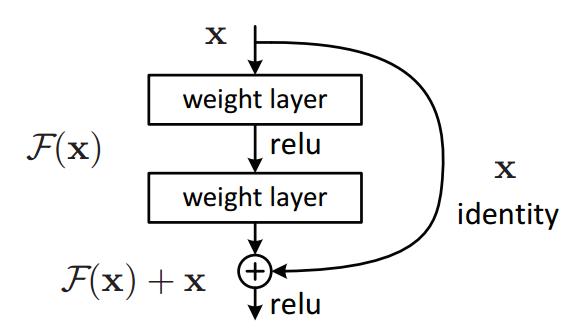

Não vamos explorar mais a fundo o funcionamento das resnets, o importante é saber que elas são redes convolucionais com bom desempenho. Após extração de features com a resnet ligamos o modelo à uma camada densa que tenta prever o valor das casas.

In [ ]:
#demora mais de 4 horas para executar, os resultados obtidos foram
#Best score: -219828.484375 using: {'lr': 0.01, 'n_layers': 3, 'n_neurons': (32, 8, 4)}

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_mlp, epochs=15, verbose=0)

#define os parametros a serem usados na gridsearch
learn_rate = [0.1, 0.01, 0.001]
n_neurons = list(itertools.permutations([4, 8, 16, 32, 64]))
n_layers = [1, 2, 3, 4, 5]

param_grid = dict(lr=learn_rate, n_neurons=n_neurons, n_layers=n_layers)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_result = grid.fit(X_train_scaled, y_train, callbacks=callback)

print(f"Best score: {grid_result.best_score_} using: {grid_result.best_params_}")

Na célula acima executamos o grid search do scikit learn para descobrir os melhores parâmetros para a MLP, variando número de camadas, número de neurônios em cada camada e taxa de aprendizado. O score obtido é negativo devido à implementação do grid search, que visa sempre maximizar a função de perda e portanto a saída é negada para que a busca funciona corretamente.

Com as funções prontas, podemos agora criar nossos modelos. Todos eles serão treinados em 20 épocas, usando early stopping para interromper o treino caso a perda obtida não esteja melhorando. Como estamos usando um modelo de regressão, a função de perda utilizada é o erro médio absoluto.

In [ ]:
mlp_model = create_mlp(3, [32, 8, 4], lr=0.1)

history = mlp_model.fit(x=X_train_scaled, y=y_train, epochs=20, validation_data=(X_val_scaled, y_val), callbacks=[callback])

Criamos a MLP usando melhores parâmetros obtidos pelo gridsearch. Podemos ver que a perda de validação está bem próxima da perda no treino, então podemos dizer que o modelo não está overfittado.

Ainda assim, o erro obtido está bem alto. Em média, o valor previsto pelo modelo difere em aproximadamente 220 mil do valor real, de acordo com o erro de validação.

In [ ]:
res_model = create_resnet(4, lr=0.1)

history = res_model.fit(cnn_train_datagen, epochs=20, validation_data=cnn_val_datagen, callbacks=[callback])

Criamos resnet usando a mesma taxa de aprendizado que usamos na MLP. Podemos ver que o resultado obtido é um pouco pior que aquele obtido na MLP, em média diferindo 225 mil do valor real. O modelo também não parece estar overfittando.

Iremos agora criar a rede final, composta por ambas a CNN e a MLP. As duas redes serão criadas sem uma camada final, e terão suas penúltimas camadas concatenadas, como na figura abaixo:

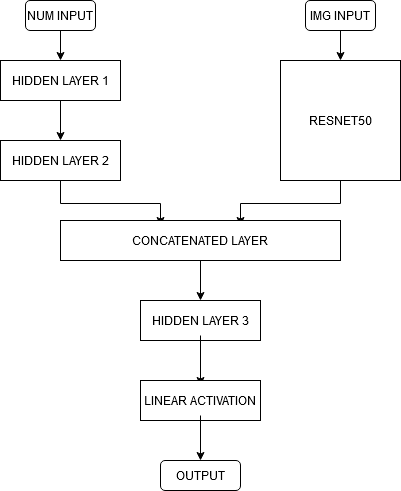



In [ ]:
mlp = create_mlp(3, [32, 8, 4], lr=0.1, regress=False)
res = create_resnet(4, lr=0.1, regress=False)

combined = layers.concatenate([mlp.output, res.output]) #concatena as duas ultimas camadas

#insere uma camada densa e a camada final com ativacao linear
x = layers.Dense(4, activation="relu")(combined)
x = layers.Dense(1, activation="linear")(x)

mlp_res_model = models.Model(inputs=[mlp.input, res.input], outputs=x)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.1, name='Adam')

mlp_res_model.compile(optimizer=opt, loss='mae')

history = mlp_res_model.fit(train_datagen, epochs=20, validation_data=val_datagen, callbacks=[callback])

In [ ]:
y_pred = mlp_res_model.predict(test_datagen)

sklearn.metrics.mean_absolute_error(y_test, y_pred)

In [ ]:
clf = GradientBoostingRegressor(n_estimators=1000).fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

sklearn.metrics.mean_absolute_error(y_test, y_pred)